In [11]:
using JLD2, UnPack
using Plots, LaTeXStrings
using Statistics

## VUMPS SIS (old and wrong)

In [2]:
data = load("../data/vumps_sis.jld2")
@unpack λ, ρ, ds, A0, ε, err, ovl, bel, AA, A, maxiter,
    ps, p_ss_montecarlo, p_ss_mpbp = data;

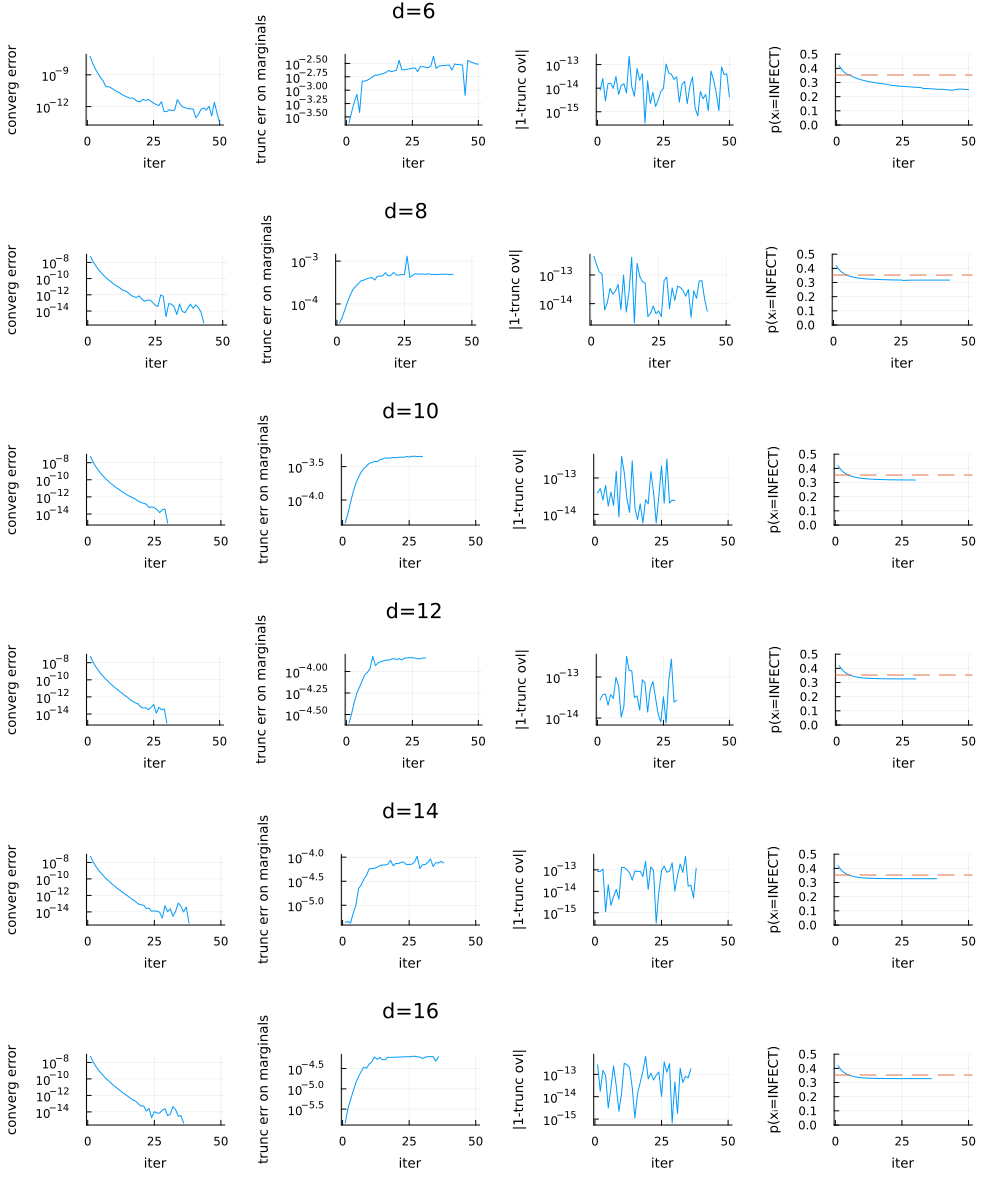

In [3]:
pls = map(zip(ε, err, ovl, ds, bel)) do (εs, errs, ovls, d, beliefs)
    p1 = plot(replace(εs, 0.0 => NaN), xlabel="iter", yaxis=:log10, ylabel="converg error", label="")
    p2 = plot(errs, xlabel="iter", yaxis=:log10, ylabel="trunc err on marginals", label="", title="d=$d")
    p3 = plot(abs.(1 .- replace(ovls, 1.0 => NaN)), xlabel="iter", yaxis=:log10, ylabel="|1-trunc ovl|", label="")
    p4 = plot([b[2] for b in beliefs], ylabel="p(xᵢ=INFECT)", ylims=(0, 0.5), label="")
    hline!(p4, [p_ss_montecarlo] , label="", ls=:dash)
    plot(p1, p2, p3, p4, layout=(1,4), size=(1200,200), margin=5Plots.mm, labelfontsize=9)
end
pl = plot(pls..., layout=(length(ds),1), size=(1000, 200*length(ds)), margin=5Plots.mm,
    xticks = 0:(maxiter÷2):maxiter, xlabel="iter")

In [4]:
x = λ / ρ
k = 3
p_ss_cme = (x*(k-1)-1) / (x*(k-1)-1 + (k-1)/k)
p_ss_gillespie = 0.33834699603960394;

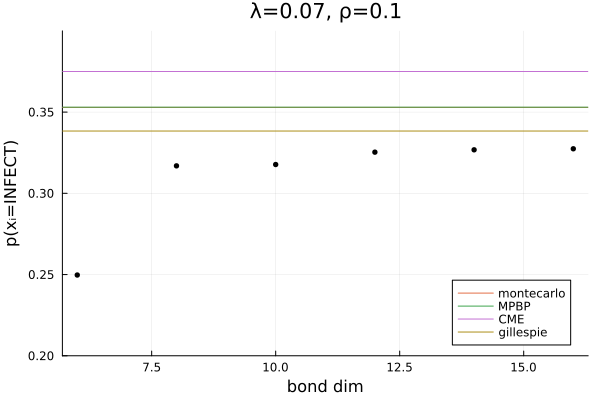

In [5]:
ps = [b[findlast(x->!all(isnan, x), b)][2] for b in bel]
pl_ps = scatter(ds, ps, xlabel="bond dim", ylabel="p(xᵢ=INFECT)", label="",
    ms=3, c=:black)
hline!(pl_ps, [p_ss_montecarlo], label="montecarlo", ylims=(0.2,0.4))
hline!(pl_ps, [p_ss_mpbp] , label="MPBP")
hline!(pl_ps, [p_ss_cme], label="CME")
hline!(pl_ps, [p_ss_gillespie], label="gillespie")
plot!(pl_ps, title="λ=$λ, ρ=$ρ")

## VUMPS Glauber

In [6]:
data = load("../data/vumps_glauber.jld2")
@unpack J, h, β, ds, A0, ε, err, ovl, bel, AA, A, maxiter,
    ps, m_ss = data;

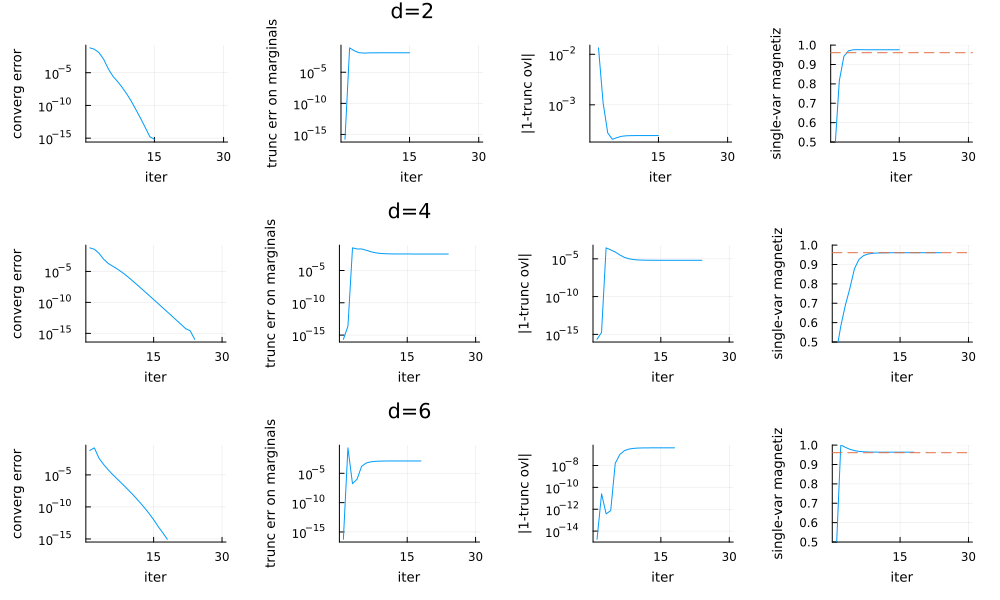

In [7]:
pls = map(zip(ε, err, ovl, ds, bel)) do (εs, errs, ovls, d, beliefs)
    p1 = plot(replace(εs, 0.0 => NaN), xlabel="iter", yaxis=:log10, ylabel="converg error", label="")
    p2 = plot(errs, xlabel="iter", yaxis=:log10, ylabel="trunc err on marginals", label="", title="d=$d")
    p3 = plot(abs.(1 .- replace(ovls, 1.0 => NaN)), xlabel="iter", yaxis=:log10, ylabel="|1-trunc ovl|", label="")
    p4 = plot([reduce(-, b) for b in beliefs], ylabel="single-var magnetiz", ylims=(0.5,1), label="")
    hline!(p4, [m_ss] , label="", ls=:dash)
    plot(p1, p2, p3, p4, layout=(1,4), size=(1200,200), margin=5Plots.mm, labelfontsize=9)
end
pl = plot(pls..., layout=(length(ds),1), size=(1000, 200*length(ds)), margin=5Plots.mm,
    xticks = 0:(maxiter÷2):maxiter, xlabel="iter")

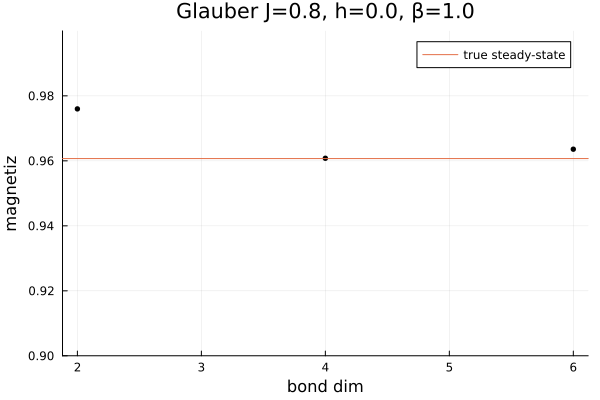

In [8]:
ps = [reduce(-, b[findlast(x->!all(isnan, x), b)]) for b in bel]
pl_ps = scatter(ds, ps, xlabel="bond dim", ylabel="magnetiz", label="",
    ms=3, c=:black)
hline!(pl_ps, [m_ss], ylims=(0.9,1.), label="true steady-state")
plot!(pl_ps, title="Glauber J=$J, h=$h, β=$β")

## SIS compare meanfield

In [9]:
data = load("../data/sis_rrg_meanfield.jld2")
@unpack T, λs, ρ, γ, N,  p_dmp_disc, p_ibmf_disc, p_cme_disc, Ts,
    p_mc, ds, p_bp = data;

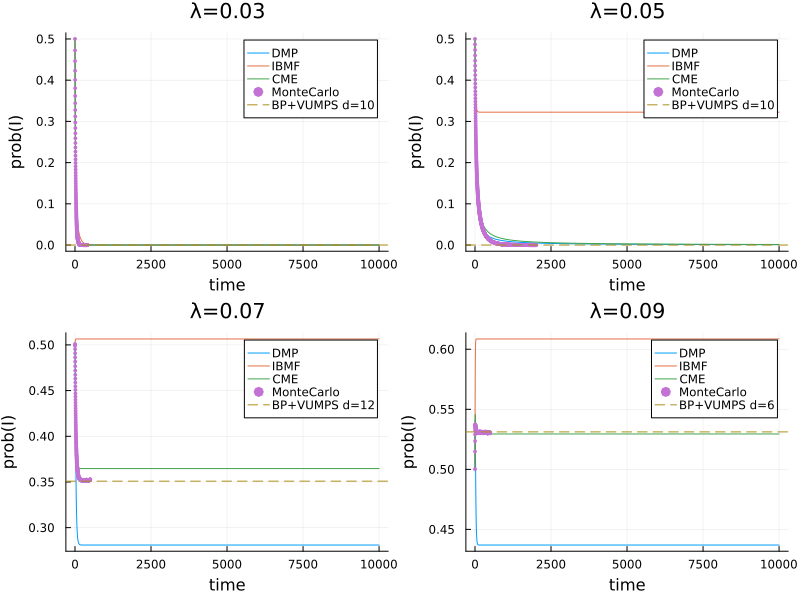

In [16]:
pls = map(eachindex(λs)) do a
    pl = plot(; xlabel="time", ylabel="prob(I)", title="λ=$(λs[a])", legend=:topright)
    plot!(pl, 0:T, mean(p_dmp_disc[a]), label="DMP")
    plot!(pl, 0:T, mean(p_ibmf_disc[a]), label="IBMF")
    plot!(pl, 0:T, mean(p_cme_disc[a]), label="CME")
    pl
end

for (pl, p, T) in zip(pls, p_mc, Ts)
    plot!(pl, 0:T, mean(p), st=:scatter, m=:o, label="MonteCarlo", msc=:auto, ms=2)
end

for (pl, p, d) in zip(pls, p_bp, ds)
    hline!(pl, 0:T, p[end][2:2], label="BP+VUMPS d=$d", ls=:dash)
end

plot(pls..., size=(800,600))

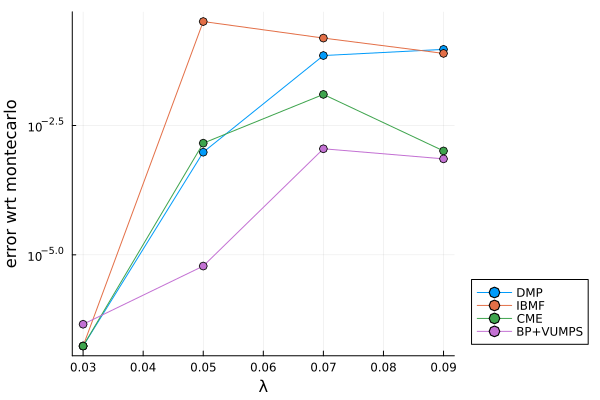

In [19]:
p_mc_ss = [mean(p[end-50:end]) for p in mean.(p_mc)]
p_dmp_ss = [p[end] for p in mean.(p_dmp_disc)]
p_cme_ss = [p[end] for p in mean.(p_cme_disc)]
p_ibmf_ss = [p[end] for p in mean.(p_ibmf_disc)]
p_bp_ss = [p[end][2] for p in p_bp]

pl = plot(; xlabel="λ", ylabel="error wrt montecarlo", yaxis=:log10, legend=:outerbottomright)
plot!(pl, λs, abs.(p_dmp_ss - p_mc_ss), label="DMP", m=:o)
plot!(pl, λs, abs.(p_ibmf_ss - p_mc_ss), label="IBMF", m=:o)
plot!(pl, λs, abs.(p_cme_ss - p_mc_ss), label="CME", m=:o)
plot!(pl, λs, abs.(p_bp_ss - p_mc_ss), label="BP+VUMPS", m=:o)